
# Objective:
---------
Train and evaluate a baseline ML model (XGBoost) to predict delivery time 
based on traffic, weather, order type, and other engineered features.

# This notebook:
1. Loads processed data or generates features from raw_orders.csv
2. Trains a regression model
3. Evaluates model performance
4. Plots feature importance
5. Exports the model for production pipeline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import os

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import os

In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))  

from src.features.build_features import build_features

import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="cool", font_scale=1.1)


In [4]:
data_path = "../data/raw_orders.csv"
df = pd.read_csv(data_path, parse_dates=["order_time"])

print("✅ Loaded raw data:", df.shape)
df.head()


✅ Loaded raw data: (500, 9)


,order_id,lat,lon,order_time,distance_km,traffic,weather,order_type,delivery_time_min
0,O00000,13.045734,77.594235,2025-10-09 02:05:18.607473,2.74,low,clear,express,5.00
1,O00001,12.966917,77.626184,2025-10-08 18:18:18.607473,10.51,low,clear,normal,24.09
2,O00002,13.026411,77.607851,2025-10-08 19:23:18.607473,0.61,high,storm,normal,5.00
3,O00003,12.997534,77.562502,2025-10-08 23:51:18.607473,0.50,medium,clear,normal,5.00
4,O00004,12.953440,77.566354,2025-10-08 21:50:18.607473,4.61,low,clear,normal,9.50


In [5]:
df, features, target = build_features(df)
print("Engineered features:", features)
print("Target:", target)

X = df[features]
y = df[target]


Engineered features: ['distance_km', 'hour', 'day_of_week', 'traffic_enc', 'weather_enc', 'order_type_enc', 'dist_x_traffic']
Target: delivery_time_min


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (400, 7)
Validation size: (100, 7)


In [7]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=4,
    verbosity=0
)

model.fit(X_train, y_train)
print("✅ Model training complete.")


✅ Model training complete.


In [ ]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f" Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


📈 Evaluation Metrics:
MAE:  2.33
RMSE: 3.36
R²:   0.820


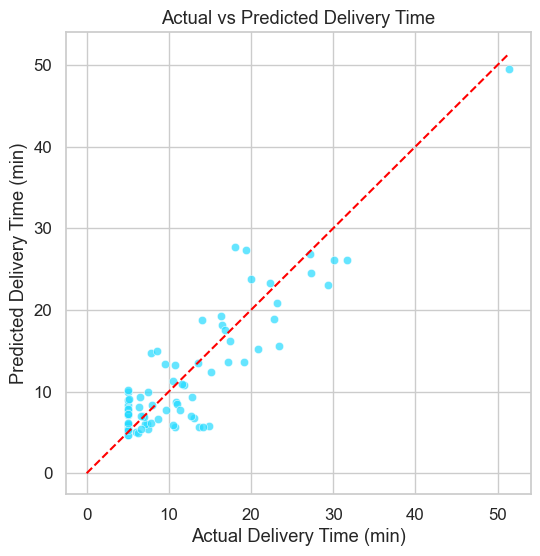

In [9]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.7)
plt.xlabel("Actual Delivery Time (min)")
plt.ylabel("Predicted Delivery Time (min)")
plt.title("Actual vs Predicted Delivery Time")
plt.plot([0, max(y_val)], [0, max(y_val)], color="red", linestyle="--")
plt.show()


C:\Users\vivek\AppData\Local\Temp\ipykernel_60240\834137269.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=imp_df, palette="crest")


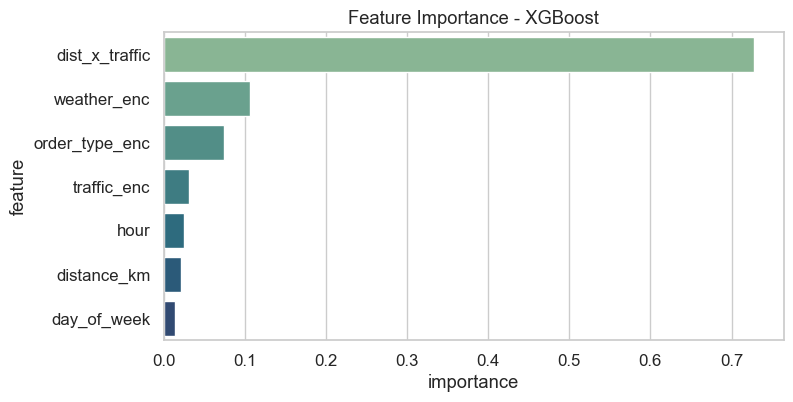

,feature,importance
6,dist_x_traffic,0.727687
4,weather_enc,0.106687
5,order_type_enc,0.074463
3,traffic_enc,0.031442
1,hour,0.024662
0,distance_km,0.021406
2,day_of_week,0.013652


In [10]:
importances = model.feature_importances_
imp_df = pd.DataFrame({"feature": features, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x="importance", y="feature", data=imp_df, palette="crest")
plt.title("Feature Importance - XGBoost")
plt.show()

imp_df


In [13]:
os.makedirs("../models", exist_ok=True)
model_path = "../models/xgb_delivery_time_model.pkl"
joblib.dump({"model": model, "features": features}, model_path)
print(f" Model artifact saved → {model_path}")


 Model artifact saved → ../models/xgb_delivery_time_model.pkl


In [14]:
metrics_path = "../models/training_metrics.csv"
metrics = pd.DataFrame([{
    "MAE": mae, "RMSE": rmse, "R2": r2,
    "n_train": len(X_train), "n_val": len(X_val)
}])
metrics.to_csv(metrics_path, index=False)
print(f" Training metrics saved → {metrics_path}")


 Training metrics saved → ../models/training_metrics.csv


In [15]:
print(" Training Summary:")
print(f"Features used: {len(features)}")
print(f"Best Feature: {imp_df.iloc[0]['feature']}")
print(f"Model performance (R²): {r2:.3f}")
print(f"Model saved at: {model_path}")


 Training Summary:
Features used: 7
Best Feature: dist_x_traffic
Model performance (R²): 0.820
Model saved at: ../models/xgb_delivery_time_model.pkl
